### Importing necessary libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#Date time
import datetime as dt
from datetime import timedelta, date

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import geopandas

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import stackstac
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
import contextily
pc.settings.set_subscription_key('b0067a12405d4fd4a4cc82d28869d9bc')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

#Scaling using Dask
import dask_gateway
import dask
import xarray as xr
from dask.distributed import Client
import dask.array as da

In [2]:
crop_presence_data = pd.read_csv("./Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


### Creating bounding boxes from the given coordinate

In [3]:
def calculate_bbox(lat_long, box_size_deg=0.0004):
    lat_long=lat_long.replace('(','').replace(')','').replace(' ','').split(',')
    
    min_lon = float(lat_long[1]) - box_size_deg/2
    min_lat = float(lat_long[0])- box_size_deg/2
    max_lon = float(lat_long[1]) + box_size_deg/2
    max_lat = float(lat_long[0]) + box_size_deg/2
    
    return min_lon, min_lat, max_lon, max_lat

#### Defining variables 

In [4]:
time_of_interest = '2021-11-01/2022-04-30'
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [5]:
rvi_df = pd.DataFrame() 
bbox = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    bbox.append(calculate_bbox(coordinates))

bbox_data = pd.DataFrame(bbox,columns =['min_lon', 'min_lat', 'max_lon', 'max_lat'])

100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 313358.54it/s]


#### Sample code to explore STAC items

In [40]:
@dask.delayed
def create_rvi_for_each_aoi(time_of_interest, bbox):
    #Creating catalog
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
    items = search.get_all_items()
    print(len(items))
    
    # Load the data using Open Data Cube
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, chunks={"x": 10240, "y": 10240}, 
                     crs="EPSG:4326", resolution=scale)

    #print(type(data))
    

    # Calculate the mean of the data across the sample region
    #mean_aoi = data.mean(dim=['latitude','longitude'])
    #print('Mean polarization', mean_aoi)

    #Calculating mean vv and vh of our area of interest
    #vh = mean_aoi["vh"]
    #vv = mean_aoi["vv"]
    #print('Vertical-vertical polarisation', vv)

    #print('Vertical-horizontal polarisation', vh)
    # Calculate RVI
    #dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
    #m = 1 - dop
    #rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))

    return data

##### Accessing images as array and dataset

In [42]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1GB')
print(client)
lazy_datasets = []
for i in range(600):
    ds = create_rvi_for_each_aoi(time_of_interest,bbox_data.iloc[i])
    lazy_datasets.append(ds)
client.close()

<Client: 'tcp://127.0.0.1:53539' processes=4 threads=8, memory=3.73 GiB>


In [43]:
lazy_datasets

[Delayed('create_rvi_for_each_aoi-0f487116-e16f-4ef9-bbbe-219e6b18baa6'),
 Delayed('create_rvi_for_each_aoi-7e0c7d82-8168-4ff5-9740-6da04fef0b24'),
 Delayed('create_rvi_for_each_aoi-15edba58-1f63-4ac6-99d9-91b343accc25'),
 Delayed('create_rvi_for_each_aoi-9e7cf29a-7bc1-43aa-ab19-1ce7d019f9cb'),
 Delayed('create_rvi_for_each_aoi-4ce6f09b-0a6e-4464-bac5-5c2794a57b3b'),
 Delayed('create_rvi_for_each_aoi-3416232b-6417-42e6-b2e8-bfba938304bc'),
 Delayed('create_rvi_for_each_aoi-f88a63b6-7f53-4b89-aa51-64104e1086f0'),
 Delayed('create_rvi_for_each_aoi-6b4a370b-dcf4-42e1-a433-e7b0064e38e7'),
 Delayed('create_rvi_for_each_aoi-a4188815-d6c6-429e-b5c8-035ecdd8b21f'),
 Delayed('create_rvi_for_each_aoi-e6790790-83c0-482a-aaed-956b6521c1f7'),
 Delayed('create_rvi_for_each_aoi-1db8f4db-7bba-42c8-9bc0-bb80cb9bf6c0'),
 Delayed('create_rvi_for_each_aoi-27dfc4b3-eb07-44da-9750-80d5f32a2405'),
 Delayed('create_rvi_for_each_aoi-2c801e41-9c64-4f84-965d-2944d804471b'),
 Delayed('create_rvi_for_each_aoi-f00a

#### Creating datasets from delayed objects

In [44]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1GB')
datasets = dask.compute(*lazy_datasets)
DS = xr.concat(datasets, dim='time')
client.close()

In [45]:
DS = xr.concat(datasets, dim='time')

In [46]:
DS

<xarray.Dataset>
Dimensions:      (latitude: 904, longitude: 1139, time: 20415)
Coordinates:
  * latitude     (latitude) float64 9.945 9.945 9.945 ... 10.48 10.48 10.48
  * longitude    (longitude) float64 104.9 104.9 104.9 ... 105.8 105.8 105.8
  * time         (time) datetime64[ns] 2021-11-04T22:45:36.411115 ... 2022-04...
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(1, 904, 1139), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 dask.array<chunksize=(1, 904, 1139), meta=np.ndarray>

#### Calculating mean scattering and radar vegetation index

In [47]:
mean_aoi = DS.mean(dim=['latitude','longitude'])
vh = mean_aoi["vh"]
vv = mean_aoi["vv"]
dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))

#### Converting xarray dataarray to series

In [ ]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1GB')
rvi_series = rvi.compute()
client.close()

In [15]:
type(datasets)

tuple

In [34]:
i = 0
for data in datasets:
    mean_aoi = data.mean(dim=['latitude','longitude'])
    #print('Mean polarization', mean_aoi)
  
    #Calculating mean vv and vh of our area of interest
    vh = mean_aoi["vh"]
    vv = mean_aoi["vv"]
    #print('Vertical-vertical polarisation', vv)

    #print('Vertical-horizontal polarisation', vh)
    #Calculate RVI
    dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))
    if i==0:
        rvi_ds = rvi.copy()
        vv_ds = vv.copy()
        vh_ds = vh.copy()
    elif i>0:
        rvi_ds = xr.merge([rvi, rvi_ds],join="inner")
        vv_ds = xr.merge([vv, vv_ds],join="inner")
        vh_ds = xr.merge([vh, vh_ds],join="inner")
    print(type(rvi_ds))
    print(type(vv_ds))
    print(type(vh_ds))
    print(type(vv))
    print(type(vh))
    print(type(rvi))
    print(i)
    i = i+1

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
0


ValueError: unable to convert unnamed DataArray to a Dataset without providing an explicit name

In [18]:
rvi

<xarray.DataArray (time: 34)>
dask.array<mul, shape=(34,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2021-11-04T22:45:36.411115 ... 2022-04...

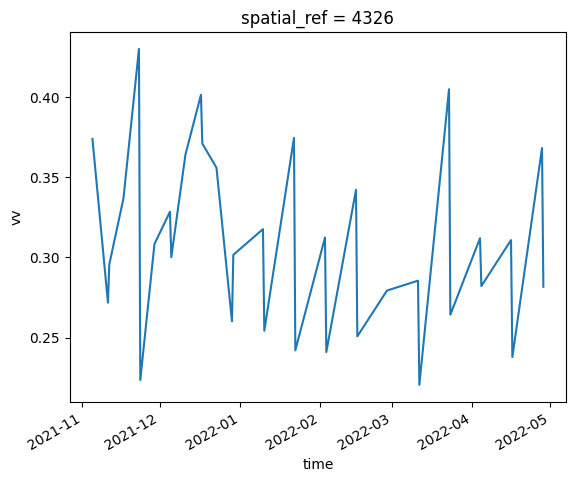

In [26]:
vv.plot()

In [129]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1.5GB')
client
lazy_datasets = []
for i, items
    print(i)
    ds = create_rvi_for_each_aoi(time_of_interest, bbox_data.iloc[i])
    lazy_datasets.append(ds)

print(type(lazy_datasets))
datasets = dask.compute(*lazy_datasets)
print(type(datasets))

#Concatenating 
DS = xr.concat(datasets, dim='time')

0
1
2
3
4
5
6
7
8
9
<class 'list'>
<class 'tuple'>


In [41]:
print('Dataset size: [Gb]', DS.nbytes/1e9)

Dataset size: [Gb] 9.2524e-05


In [108]:
def convert_xarraydataset_to_dataframe(ddf):
    mean_aoi = ddf.groupby(['time'])['latitude', 'longitude'].mean()
    #mean_aoi = ddf.mean(dim=['latitude','longitude']).compute()
    #print('Mean polarization', mean_aoi)

    #Calculating mean vv and vh of our area of interest
    vh = mean_aoi["vh"]
    vv = mean_aoi["vv"]
    #print('Vertical-vertical polarisation', vv)

    #print('Vertical-horizontal polarisation', vh)
    # Calculate RVI
    dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
    m = 1 - dop
    rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))
    
    return rvi, vv, vh

#### Converting xarray dataset to dask dataframe

In [131]:
mean_aoi = DS.mean(dim=['latitude','longitude'])
#print('Mean polarization', mean_aoi)

#Calculating mean vv and vh of our area of interest
vh = mean_aoi["vh"]
vv = mean_aoi["vv"]
#print('Vertical-vertical polarisation', vv)

#print('Vertical-horizontal polarisation', vh)
# Calculate RVI
dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))

In [101]:
ddf

,latitude,longitude,time,spatial_ref,vv,vh
npartitions=37,,,,,,
0,float64,float64,datetime64[ns],int32,float32,float32
32940,...,...,...,...,...,...
...,...,...,...,...,...,...
1185840,...,...,...,...,...,...
1218779,...,...,...,...,...,...


In [ ]:
vh_vv_data = pd.DataFrame(list(zip(vh_series,vv_series,rvi_series)),columns = ["vv_list","vh_list","rvi_list"])

#### Starting Dask distribution

In [64]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='1.5GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59033/status,
Dashboard: http://127.0.0.1:59033/status,Workers: 4
Total threads: 8,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59034,Workers: 4
Dashboard: http://127.0.0.1:59033/status,Total threads: 8
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:59056,Total threads: 2
Dashboard: http://127.0.0.1:59063/status,Memory: 1.40 GiB
Nanny: tcp://127.0.0.1:59037,


#### Lazily append all datasets

In [65]:
lazy_datasets = []
for i,item in bbox_data.iterrows():
    print(i)
    ds = create_rvi_for_each_aoi(time_of_interest, item)
    lazy_datasets.append(ds)

datasets = dask.compute(*lazy_datasets)

#Concatening 
DS = xr.concat(datasets, dim='time')

#Creating mean VV, VH Scattering
# Calculate the mean of the data across the sample region
mean_aoi = DS.mean(dim=['latitude','longitude'])
#print('Mean polarization', mean_aoi)

#Calculating mean vv and vh of our area of interest
vh = mean_aoi["vh"]
vv = mean_aoi["vv"]
#print('Vertical-vertical polarisation', vv)

#print('Vertical-horizontal polarisation', vh)
# Calculate RVI
dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
m = 1 - dop
rvi = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2023-03-12 13:29:41,701 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


In [110]:
type(DS)

xarray.core.dataset.Dataset